In [106]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

In [107]:
dataset_file = "../deepchem/datasets/gdb1k.sdf"
smiles_field = "smiles"
mol_field = "mol"
featurizer = dc.feat.CoulombMatrixEig(23, remove_hydrogens=False)

loader = dc.data.SDFLoader(
      tasks=["atomization_energy"], smiles_field="smiles",
      featurizer=featurizer,
      mol_field="mol")
dataset = loader.featurize(dataset_file)


Loading raw samples now.
shard_size: 8192
Reading structures from ../deepchem/datasets/gdb1k.sdf.
Currently featurizing feature_type: CoulombMatrixEig
Featurizing sample 0
TIMING: featurizing shard 0 took 0.659 s
TIMING: dataset construction took 0.903 s
Loading dataset from disk.


In [114]:
# Split dataset
random_splitter = dc.splits.RandomSplitter()
#stratified_splitter = dc.splits.RandomStratifiedSplitter(
train_dataset, valid_dataset, test_dataset = random_splitter.train_valid_test_split(dataset)

# Apply normalisation transformer
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
    for transformer in transformers:
        dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.008 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.008 s
Loading dataset from disk.
TIMING: dataset construction took 0.007 s
Loading dataset from disk.


train ((792, 23), (792, 1), (792, 1), (792,))
valid ((99, 23), (99, 1), (99, 1), (99,))
test ((100, 23), (100, 1), (100, 1), (100,))


RDKit ERROR: [18:00:00] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [18:00:00] Explicit valence for atom # 2 N, 4, is greater than permitted


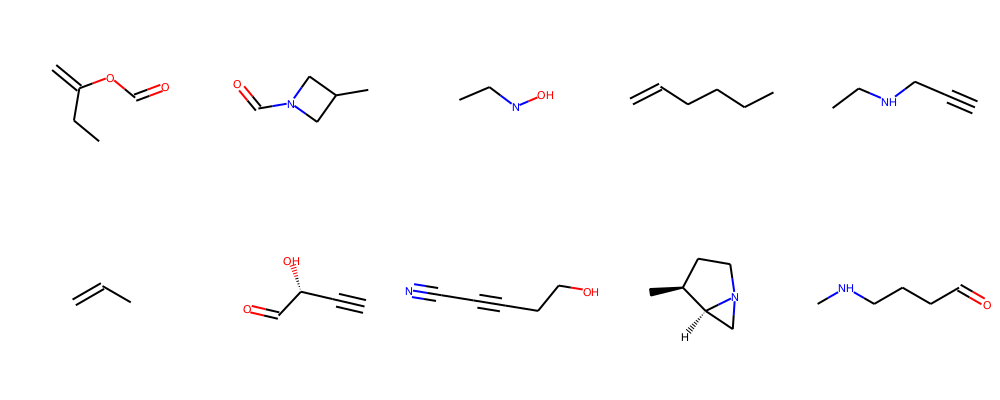

In [115]:
## Dataset analysis

def moltosvg(mol,molSize=(280,80),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

for data, name in zip([train_dataset, valid_dataset, test_dataset],['train', 'valid', 'test']):
    print(name, data.get_shape())
   # print(name, data.get_statistics())
    mol_list = [Chem.MolFromSmiles(id_) for id_ in data.ids]
    #SVG(moltosvg(mol_list[0]))

Chem.Draw.MolsToGridImage(mol_list[:10], molsPerRow=5)#legends=[mol.GetProp('_Name') for mol in mol_list[:10]])

# mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
# Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])

## Keras Neural Networks

In [116]:
## Functions

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    ax[0].set_title(title)
    #plt.ylim([0,5])
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    ax[1].set_title(title)
    ax[1].legend()
    plt.show()

In [150]:
## Keras implementation 
from tensorflow import keras

# Sigmoid activation function 

model = tf.keras.Sequential([
keras.layers.Dense(400, activation='sigmoid', input_shape=(23,)),
keras.layers.Dense(100, activation='sigmoid'),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

# Configure a model for mean-squared error regression.
model.compile(optimizer='sgd',
              loss='mse',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

X_train = train_dataset.X
y_train = train_dataset.y

In [151]:
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=1000, 
                    callbacks=[early_stop], batch_size=30, verbose=0)


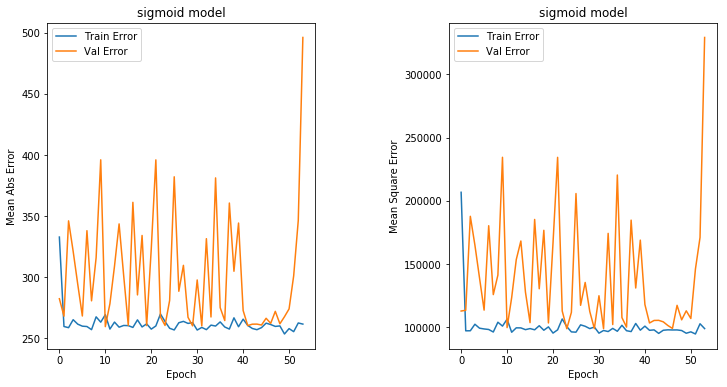

In [152]:
plot_history(history, "sigmoid model")

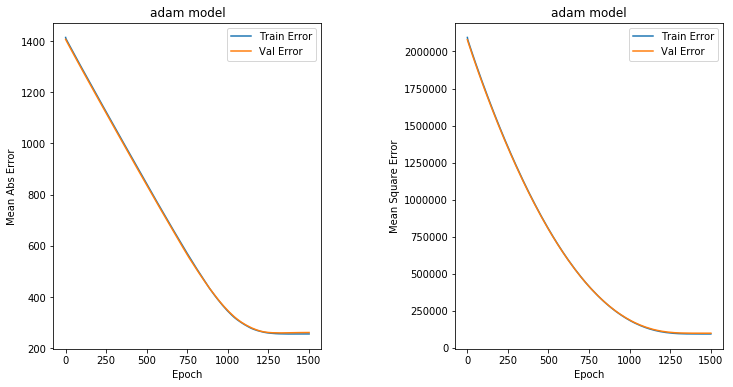

In [155]:
# Configure a model for mean-squared error regression.
model_adam = tf.keras.Sequential([
keras.layers.Dense(400, activation='sigmoid', input_shape=(23,)),
keras.layers.Dense(100, activation='sigmoid'),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

initializer = keras.initializers.RandomNormal(mean=0, std=(1/np.sqrt(100)))

model_adam.compile(optimizer='adam',
              loss='mse',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

history_adam = model_adam.fit(X_train, y_train, validation_split = 0.2, epochs=2000, 
                    callbacks=[early_stop], batch_size=30, verbose=0)

plot_history(history_adam, "adam model")

## DeepChem Multitask Regressor

In [132]:
from deepchem.molnet import load_qm7_from_mat
from deepchem.models.tensorgraph.optimizers import ExponentialDecay

print(tf.__version__)

qm7_tasks, datasets, transformers = load_qm7_from_mat(
    split='stratified', move_mean=True, reload=False)


qm_train, qm_valid, qm_test = datasets

fit_transformers = [dc.trans.CoulombFitTransformer(qm_train)]

rate = 0.001
dc_model = dc.models.MultitaskFitTransformRegressor(
    n_tasks=1,
    n_features=[23, 23],
    learning_rate=rate,
    momentum=.8,
    batch_size=25,
    weight_init_stddevs=[1 / np.sqrt(400), 1 / np.sqrt(100), 1 / np.sqrt(100)],
    bias_init_consts=[0., 0., 0.],
    layer_sizes=[400, 100, 100],
    dropouts=[0.01, 0.01, 0.01],
    fit_transformers=fit_transformers,
    n_evals=10,
    seed=123)




1.13.1
TIMING: dataset construction took 0.334 s
Loading dataset from disk.
TIMING: dataset construction took 0.276 s
Loading dataset from disk.
TIMING: dataset construction took 0.114 s
Loading dataset from disk.
TIMING: dataset construction took 0.113 s
Loading dataset from disk.
TIMING: dataset construction took 0.213 s
Loading dataset from disk.
TIMING: dataset construction took 0.036 s
Loading dataset from disk.
TIMING: dataset construction took 0.032 s
Loading dataset from disk.


In [133]:
# Fit trained model
dc_model.fit(qm_train, nb_epoch=50)

train_scores = dc_model.evaluate(qm_train, metric, transformers)
valid_scores = dc_model.evaluate(qm_valid, metric, transformers)

InvalidArgumentError: You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?]
	 [[node input_4 (defined at /Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py:221) ]]

Caused by op 'input_4', defined at:
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-132-fc55a474e534>", line 27, in <module>
    seed=123)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py", line 346, in __init__
    n_tasks, n_features, batch_size=batch_size, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py", line 221, in __init__
    dropout_switch = Input(shape=tuple())
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/keras/engine/input_layer.py", line 231, in Input
    input_tensor=tensor)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/keras/engine/input_layer.py", line 107, in __init__
    name=self.name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/keras/backend.py", line 876, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5791, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input_4' with dtype float and shape [?]
	 [[node input_4 (defined at /Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/deepchem/models/tensorgraph/fcnet.py:221) ]]


In [ ]:
def krr_model_builder(model_params, model_dir):
    sklearn_model = KernelRidge(**model_params)
    return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "kernel": ["laplacian", "linear"],
    "alpha": [0.0001, 0.001, 0.01, 0.01],
    "gamma": [0.0001, 0.001, 0.01, 0.1]
}

metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)

optimizer = dc.hyper.HyperparamOpt(krr_model_builder)
best_krr, best_krr_hyperparams, all_krr_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)
